In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [8]:
# Cargar datos y setear time
df = pd.read_csv('sample_data/ads.csv')
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)

In [9]:
# Identificar y manejar valores atípicos usando el método del IQR
Q1 = df['Ads'].quantile(0.25)
Q3 = df['Ads'].quantile(0.75)
IQR = Q3 - Q1
outliers = (df['Ads'] < (Q1 - 1.5 * IQR)) | (df['Ads'] > (Q3 + 1.5 * IQR))
df.loc[outliers, 'Ads'] = np.nan

In [10]:
# Interpolación para rellenar valores atípicos
df['Ads'].interpolate(method='linear', inplace=True)

<ipython-input-10-136925f9d85f>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Ads'].interpolate(method='linear', inplace=True)


In [11]:
# transformar y escalar datos

# Escalar los datos
scaler = MinMaxScaler()
df['Ads_scaled'] = scaler.fit_transform(df[['Ads']])

# Transformación logarítmica
df['Ads_log'] = np.log(df['Ads_scaled'] + 1)

In [12]:
# Construir el Time-Delay Embedding
def create_time_lagged_features(data, lag=3):
    """Crea características con desfase temporal."""
    lagged_data = pd.DataFrame()
    for i in range(1, lag + 1):
        lagged_data[f'lag_{i}'] = data.shift(i)
    return lagged_data

In [13]:
# Crear características con desfase temporal
df_lagged = create_time_lagged_features(df['Ads_log'])
df_combined = pd.concat([df['Ads_log'], df_lagged], axis=1).dropna()

In [14]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X = df_combined.drop(columns=['Ads_log'])
y = df_combined['Ads_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [15]:
# Entrenar el modelo SVR
model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
model.fit(X_train, y_train)

SVR(C=100, gamma=0.1)

In [16]:
# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

In [17]:
# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

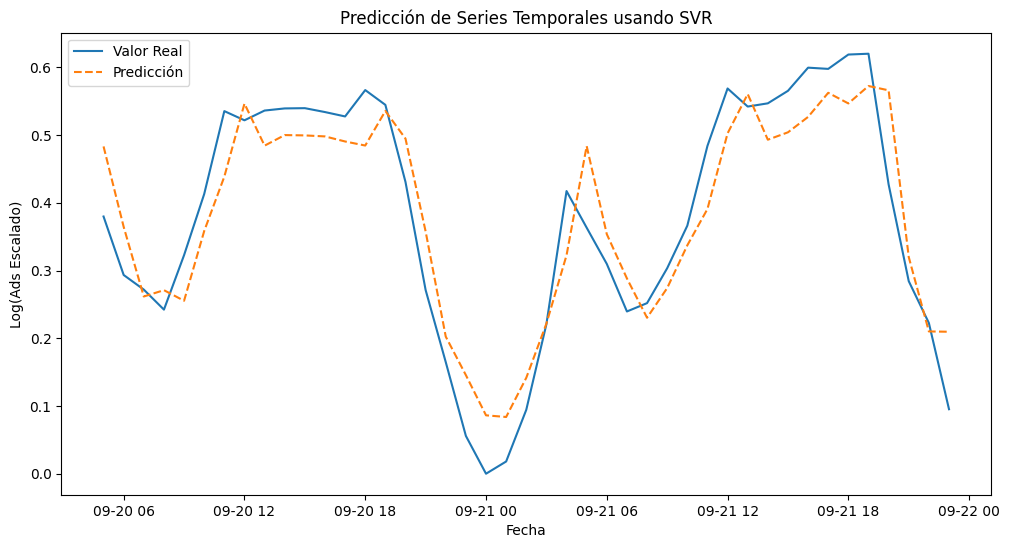

MSE: 0.004242100968975882, MAE: 0.05674979669342702


In [18]:
# Graficar las predicciones
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Valor Real')
plt.plot(y_test.index, y_pred, label='Predicción', linestyle='--')
plt.title('Predicción de Series Temporales usando SVR')
plt.xlabel('Fecha')
plt.ylabel('Log(Ads Escalado)')
plt.legend()
plt.show()

print(f'MSE: {mse}, MAE: {mae}')

El resultado muestra un análisis de series temporales de datos de anuncios (Ads) recopilados por hora durante un período de 9 días, del 13 al 21 de septiembre de 2017. El método empleado consistió en varios pasos clave:

1. Limpieza de datos: Se identificaron y manejaron valores atípicos utilizando el método del rango intercuartílico (IQR).

2. Escalado y transformación: Se aplicó una normalización MinMax para escalar los datos entre 0 y 1, seguida de una transformación logarítmica para estabilizar la varianza.

3. Time-delay embedding: Se crearon características con desfase temporal para capturar patrones secuenciales en los datos.

4. Modelado: Se utilizó un modelo de Support Vector Regression (SVR) para realizar predicciones.

5. Evaluación: Se calcularon métricas de error como el Mean Squared Error (MSE) y Mean Absolute Error (MAE) para evaluar el rendimiento del modelo.

Los resultados (MSE: 0.0042, MAE: 0.0567) indican un buen ajuste del modelo, con predicciones cercanas a los valores reales. El bajo MSE sugiere que las diferencias cuadráticas entre predicciones y valores reales son pequeñas, mientras que el MAE confirma que, en promedio, las predicciones están muy próximas a los valores observados.

Este enfoque permitió capturar eficazmente los patrones temporales en los datos de anuncios, proporcionando una base sólida para predicciones futuras y análisis de tendencias.